<a href="https://colab.research.google.com/github/diegol99/CasoEstudio_Seguros/blob/main/Caso_de_Estudio_Finanzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Librerias y lecturas de BD**

In [64]:
#Acceder al drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
pip install git+https://github.com/amueller/dabl/ 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/amueller/dabl/ to /tmp/pip-req-build-wkzkid94
  Running command git clone --filter=blob:none --quiet https://github.com/amueller/dabl/ /tmp/pip-req-build-wkzkid94
  Resolved https://github.com/amueller/dabl/ to commit a9bd5943121b12135e8efb241c6c8269275e744b
  Preparing metadata (setup.py) ... done


In [66]:
#Cargar librerias
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.graph_objects as go ## Para gráficos
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import dabl
#Escalar, estandarizar y normalizar
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
#Seleccion de variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions


# Para ejecutar sql y conectarse a bd

conn = sql.connect('/content/drive/MyDrive/Analitica 3/Financiero/BD_insurance2019dataset.db') ## Crear cuando no existe el nombre cd y conectarse cuando si existe
cur=conn.cursor() # Para funciones que ejecutan sql en base de datos
cur.execute ("SELECT name FROM sqlite_master Where type = 'table';")
print(cur.fetchall())

[('reclamaciones',), ('diagnosticos',), ('regional',), ('genero',), ('sociodemograficas',), ('utilizaciones',)]


##**Tipos de datos de BD**

In [67]:
#Que tipos de datos contiene cada base
def tiposdatos (x):
    return x.dtypes

In [68]:
#Cargar bases de datos
reclam = pd.read_sql('SELECT * FROM reclamaciones', conn) ##Tipos de reclamaciones: Atención del parto, Atencion integral de salud mental
diag = pd.read_sql('SELECT * FROM diagnosticos', conn) ## Diagnosticos de los pacientes
regional = pd.read_sql('SELECT * FROM regional', conn) ## Lugares 
genero = pd.read_sql('SELECT * FROM genero', conn) #Genero
sociodemo = pd.read_sql('SELECT * FROM sociodemograficas', conn) ## datos de pacientes sociodemograficos
util = pd.read_sql('SELECT * FROM utilizaciones', conn) ##información completa del paciencie con su precio

In [69]:
#Cantidad de veces que se repite un diagnostico 
util["Diagnostico_Codigo"].value_counts()

9       343246
Z108      6773
Z017      6470
E039      2441
E139      1086
         ...  
I260         1
Q658         1
Q420         1
F116         1
M619         1
Name: Diagnostico_Codigo, Length: 2724, dtype: int64

In [70]:
#Tipos de variables en cada base
print(tiposdatos(reclam))
print(tiposdatos(diag))
print(tiposdatos(regional))
print(tiposdatos(genero))

Reclamacion_Id       int64
Reclamacion_Desc    object
dtype: object
Diagnostico_Codigo    object
Diagnostico_Desc      object
dtype: object
Regional_id       int64
Regional_Desc    object
dtype: object
Sexo_Cd      object
Sexo_desc    object
dtype: object


In [71]:
tiposdatos(sociodemo)

Afiliado_Id            int64
Sexo_codigo           object
FechaNacimiento        int64
Regional_codigo       object
CANCER                 int64
EPOC                   int64
DIABETES               int64
HIPERTENSION           int64
ENF_CARDIOVASCULAR     int64
dtype: object

In [72]:
tiposdatos(util)

Fecha_Reclamacion      object
Afiliado_Id             int64
Reclamacion_codigo     object
Diagnostico_Codigo     object
Cantidad              float64
Precio                float64
dtype: object

In [73]:
#Descripción de la base sociodemo
sociodemo.describe()

,Afiliado_Id,FechaNacimiento,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
count,2.182050e+05,218205.000000,218205.000000,218205.000000,218205.000000,218205.000000,218205.000000
mean,2.470483e+07,31646.927156,0.019014,0.005114,0.014844,0.069600,0.004047
std,1.694923e+07,7114.943973,0.136575,0.071332,0.120928,0.254472,0.063485
min,7.382880e+05,5146.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.569969e+06,26913.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.350590e+07,31194.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.913018e+07,37507.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.957157e+07,45387.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
util.describe()

,Afiliado_Id,Cantidad,Precio
count,3.958680e+05,395868.000000,3.958680e+05
mean,2.094687e+07,1.504469,2.896047e+05
std,1.653072e+07,2.343573,2.088676e+06
min,7.382880e+05,0.000000,2.480000e+00
25%,5.742196e+06,1.000000,5.415080e+04
50%,1.657348e+07,1.000000,6.810266e+04
75%,3.422113e+07,1.000000,1.423250e+05
max,5.956476e+07,210.000000,5.410007e+08


In [75]:
#Que cantidad de nulos tiene, tamaño de base y tipo de cada columna 
sociodemo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218205 entries, 0 to 218204
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Afiliado_Id         218205 non-null  int64 
 1   Sexo_codigo         218205 non-null  object
 2   FechaNacimiento     218205 non-null  int64 
 3   Regional_codigo     218205 non-null  object
 4   CANCER              218205 non-null  int64 
 5   EPOC                218205 non-null  int64 
 6   DIABETES            218205 non-null  int64 
 7   HIPERTENSION        218205 non-null  int64 
 8   ENF_CARDIOVASCULAR  218205 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 15.0+ MB


In [76]:
util.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395868 entries, 0 to 395867
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Fecha_Reclamacion   395868 non-null  object 
 1   Afiliado_Id         395868 non-null  int64  
 2   Reclamacion_codigo  395868 non-null  object 
 3   Diagnostico_Codigo  395868 non-null  object 
 4   Cantidad            395868 non-null  float64
 5   Precio              395868 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.1+ MB


## ***Análisis exploratorio de utilizaciones medicas***

In [77]:
#Grafica serie de tiempo de reclamaciones anuales
util["Fecha_Reclamacion"] = pd.to_datetime(util["Fecha_Reclamacion"])
import plotly.express as px
util["Fecha_Reclamacion"] = util["Fecha_Reclamacion"].dt.year
retfecha= util.groupby(["Fecha_Reclamacion"])[["Afiliado_Id"]].count().reset_index()
fig = px.line(retfecha, x='Fecha_Reclamacion', y =['Afiliado_Id'], title = '<b>Reclamaciones Anuales<b>',
              color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5,
   legend_title = 'Afiliados',
    xaxis_title = '<b>Años<b>',
    yaxis_title = '<b>Cantidad de usuarios<b>',
)
fig.show()

<ipython-input-77-36392b9e3948>:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [78]:
##Serie de tiempo para los meses donde más se han reclamado
reclam = pd.read_sql('SELECT * FROM reclamaciones', conn) ##Tipos de reclamaciones: Atención del parto, Atencion integral de salud mental
diag = pd.read_sql('SELECT * FROM diagnosticos', conn) ## Diagnosticos de los pacientes
regional = pd.read_sql('SELECT * FROM regional', conn) ## Lugares 
genero = pd.read_sql('SELECT * FROM genero', conn) #Genero
sociodemo = pd.read_sql('SELECT * FROM sociodemograficas', conn) ## datos de pacientes
util = pd.read_sql('SELECT * FROM utilizaciones WHERE Fecha_Reclamacion LIKE "%2019%"', conn) ##
util["Fecha_Reclamacion"] = pd.to_datetime(util["Fecha_Reclamacion"])
import plotly.express as px
util["Fecha_Reclamacion"] = util["Fecha_Reclamacion"].dt.month
retfecha= util.groupby(["Fecha_Reclamacion"])[["Afiliado_Id"]].count().reset_index()
fig = px.line(retfecha, x='Fecha_Reclamacion', y =['Afiliado_Id'], title = '<b>Reclamaciones en el 2019<b>',
              color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5,
   legend_title = 'Afiliados',
    xaxis_title = '<b>Mes<b>',
    yaxis_title = '<b>Cantidad de usuarios<b>',
)
fig.show()

<ipython-input-78-51213edc490e>:8: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [79]:
util["Fecha_Reclamacion"].value_counts

<bound method IndexOpsMixin.value_counts of 0         10
1         11
2         10
3         11
4          8
          ..
394881    11
394882     7
394883    10
394884    11
394885    10
Name: Fecha_Reclamacion, Length: 394886, dtype: int64>

In [80]:
#Filtrar meses de mayor reclamación en el 2019
util=util[util["Fecha_Reclamacion"]>=9]
util

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio
0,10,22914637,12,M45X,1.0,1056639.96
1,11,58412744,9,9,1.0,139772.80
2,10,5070923,16,9,1.0,320166.76
3,11,5769950,13,9,1.0,21204.00
5,11,17126150,16,9,1.0,160700.28
...,...,...,...,...,...,...
394880,11,15648118,13,9,1.0,21204.00
394881,11,4351189,16,9,15.0,251820.44
394883,10,19220270,13,9,10.0,475726.00
394884,11,25627716,12,9,2.0,568788.00


In [81]:
## Numero de reclamaciones por afiliado
pd.read_sql('SELECT Afiliado_Id, count(Afiliado_Id) as Cantidad FROM utilizaciones GROUP BY Afiliado_Id ORDER BY Cantidad DESC LIMIT 5;', conn)

,Afiliado_Id,Cantidad
0,24695323,173
1,56682173,124
2,9732625,60
3,32520762,52
4,40867244,51


In [82]:
##Que tipo de reclamo es más frecuente

numreclam = pd.read_sql('''SELECT Reclamacion_Desc as 'Tipo de Reclamo', count(Reclamacion_codigo) as Cantidad FROM utilizaciones 
                            INNER JOIN reclamaciones
                            ON utilizaciones.Reclamacion_codigo = reclamaciones.Reclamacion_Id
                            GROUP BY Reclamacion_codigo 
                            ORDER BY Cantidad DESC 
                            LIMIT 5;''', conn)
numreclam

,Tipo de Reclamo,Cantidad
0,CONSULTA EXTERNA,154150
1,EXAMENES DE DIAGNOSTICO,73311
2,LABORATORIO CLINICO,56405
3,CONSULTA DE URGENCIAS,38241
4,FISIOTERAPIA ILIMITADA,38121


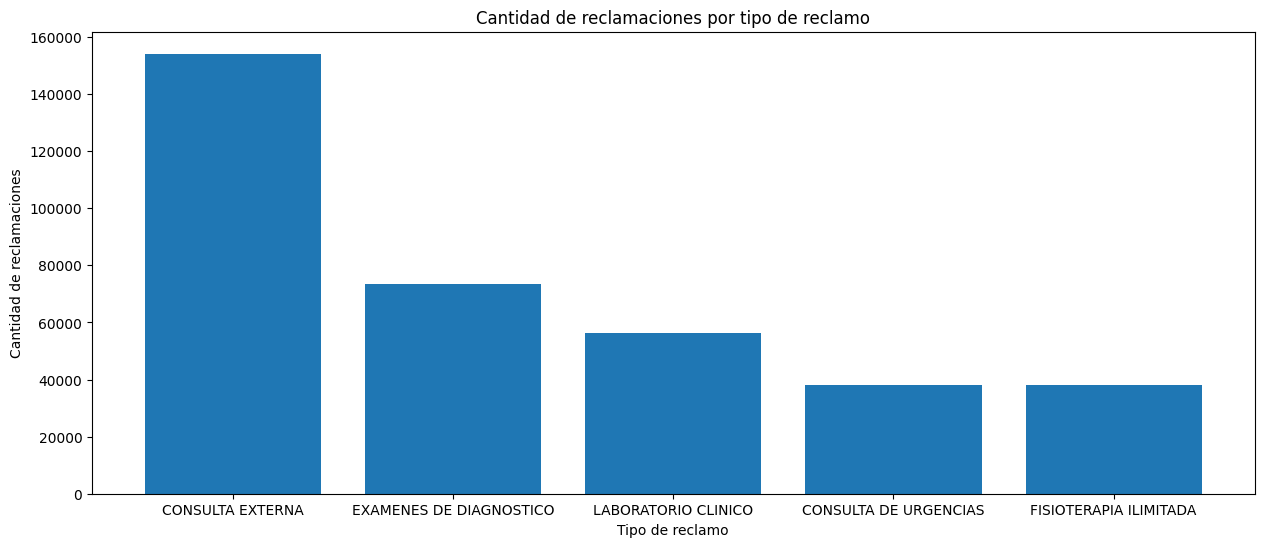

In [83]:
#Grafico de cantidad de reclamaciones por tipo de reclamos
# Configuración de gráfico de barras verticales
plt.bar(numreclam['Tipo de Reclamo'], numreclam['Cantidad'])

# Configuración de títulos y etiquetas de ejes
plt.title('Cantidad de reclamaciones por tipo de reclamo')
plt.xlabel('Tipo de reclamo')
plt.ylabel('Cantidad de reclamaciones')
plt.rcParams["figure.figsize"] = (15,6)

# Mostrar el gráfico
plt.show()

In [84]:
##Qué diagnóstico se repite más
Diagnonum = pd.read_sql('''SELECT Diagnostico_Codigo,count(Diagnostico_Codigo) as Cantidad FROM utilizaciones
                            GROUP BY Diagnostico_Codigo
                            ORDER BY Cantidad DESC
                            LIMIT 12
                            ;''', conn)
Diagnonum

,Diagnostico_Codigo,Cantidad
0,9,343246
1,Z108,6773
2,Z017,6470
3,E039,2441
4,E139,1086
5,E119,967
6,R529,898
7,Z018,832
8,Z321,690
9,Z008,630


In [85]:
#Hacer inner para que salga el nombre de diagnostico y el codigo con la cantidad de apariciones
Inner = pd.merge(Diagnonum,diag,how="inner")
Inner

,Diagnostico_Codigo,Cantidad,Diagnostico_Desc
0,9,343246,DIAGNÓSTICO PENDIENTE
1,Z108,6773,OTROS CONTROLES GENERALES DE SALUD DE RUTINA D...
2,Z017,6470,EXAMEN DE LABORATORIO
3,E039,2441,"HIPOTIROIDISMO, NO ESPECIFICADO"
4,E139,1086,"DIABETES MELLITUS ESPECIFICADA, SIN MENCIÓN DE..."
5,E119,967,"DIABETES MELLITUS NO INSULINODEPENDIENTE, SIN ..."
6,R529,898,"DOLOR, NO ESPECIFICADO"
7,Z018,832,OTROS EXÁMENES ESPECIALES ESPECIFICADOS
8,Z321,690,EMBARAZO CONFIRMADO
9,Z008,630,OTROS EXÁMENES GENERALES


## ***Análisis exploratorio de Sociodemo***



In [86]:
#Conteo por region
regionalmás = pd.read_sql('''SELECT Regional_Desc,count(Regional_codigo) as Cantidad  FROM sociodemograficas
                            INNER JOIN regional
                            ON sociodemograficas.Regional_codigo = regional.Regional_id
                            GROUP BY Regional_Desc
                            ORDER BY cantidad Desc;''', conn)
regionalmás

,Regional_Desc,Cantidad
0,REGIONAL CENTRO,106907
1,REGIONAL ANTIOQUIA,39582
2,REGIONAL OCCIDENTE,36030
3,REGIONAL NORTE,28259
4,REGIONAL EJE CAFETERO,7377
5,Sin Información,49


In [87]:
#Qué genero se presenta con más frecuencia
pd.read_sql('SELECT Sexo_codigo, count(Sexo_codigo) as NumGen FROM sociodemograficas GROUP BY Sexo_codigo;', conn)

,Sexo_codigo,NumGen
0,-1,1
1,F,119253
2,M,98951


In [88]:
#Afiliados con cancer
pd.read_sql('SELECT count(CANCER) as NumpCancer FROM sociodemograficas GROUP BY CANCER;', conn)

,NumpCancer
0,214056
1,4149


In [89]:
#Afiliados que presentan EPOC
pd.read_sql('SELECT count(EPOC) as NumpEpoc FROM sociodemograficas GROUP BY EPOC;', conn)

,NumpEpoc
0,217089
1,1116


In [90]:
#Afiliados con diabetes
pd.read_sql('SELECT count(DIABETES) as NumpDiab FROM sociodemograficas GROUP BY DIABETES;', conn)

,NumpDiab
0,214966
1,3239


In [91]:
#Cantidad de afiliados con hipertensión
pd.read_sql('SELECT count(HIPERTENSION) as NumpHiper FROM sociodemograficas GROUP BY HIPERTENSION;', conn)

,NumpHiper
0,203018
1,15187


In [92]:
#Afiliados que presentan o no enfermedades cardiovasculares
pd.read_sql('SELECT count(ENF_CARDIOVASCULAR) as NumpCardiovascular FROM sociodemograficas GROUP BY ENF_CARDIOVASCULAR;', conn)

,NumpCardiovascular
0,217322
1,883


In [93]:
# Verificación de valores nulos en cada tabla
print("Valores nulos en la tabla de reclamaciones:")
print(reclam.isnull().sum())

print("Valores nulos en la tabla de diagnósticos:")
print(diag.isnull().sum())

print("Valores nulos en la tabla regional:")
print(regional.isnull().sum())

print("Valores nulos en la tabla de género:")
print(genero.isnull().sum())

print("Valores nulos en la tabla de datos sociodemográficos:")
print(sociodemo.isnull().sum())

print("Valores nulos en la tabla de utilizaciones:")
print(util.isnull().sum())

Valores nulos en la tabla de reclamaciones:
Reclamacion_Id      0
Reclamacion_Desc    0
dtype: int64
Valores nulos en la tabla de diagnósticos:
Diagnostico_Codigo    0
Diagnostico_Desc      0
dtype: int64
Valores nulos en la tabla regional:
Regional_id      0
Regional_Desc    0
dtype: int64
Valores nulos en la tabla de género:
Sexo_Cd      0
Sexo_desc    0
dtype: int64
Valores nulos en la tabla de datos sociodemográficos:
Afiliado_Id           0
Sexo_codigo           0
FechaNacimiento       0
Regional_codigo       0
CANCER                0
EPOC                  0
DIABETES              0
HIPERTENSION          0
ENF_CARDIOVASCULAR    0
dtype: int64
Valores nulos en la tabla de utilizaciones:
Fecha_Reclamacion     0
Afiliado_Id           0
Reclamacion_codigo    0
Diagnostico_Codigo    0
Cantidad              0
Precio                0
dtype: int64


##**Transformación Sociodemo**

In [94]:
sociodemo

,Afiliado_Id,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
0,738288,M,28072,1,0,0,0,0,0
1,738294,M,23392,2,0,0,0,0,0
2,738303,F,27177,3,0,0,0,0,0
3,738318,M,15053,2,1,0,1,1,0
4,738323,F,10447,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218200,59559606,F,38164,2,0,0,0,0,0
218201,59564764,F,38429,2,0,0,0,0,0
218202,59565065,F,38425,2,0,0,0,0,0
218203,59570753,M,27839,4,0,0,0,0,0


In [95]:
#Transformar la fecha y sexo
sociodemo['Sexo_codigo'] = sociodemo['Sexo_codigo'].apply(lambda x: 0 if x == "F" else 1 if x == "M" else 0)
sociodemo['FechaNacimiento']=sociodemo['FechaNacimiento'].apply(lambda x: datetime.datetime(1899, 12, 30) + datetime.timedelta(days=x))

In [96]:
#Cantidad de valores y unificar categoría de region
sociodemo["Regional_codigo"].value_counts()
sociodemo['Regional_codigo'] = sociodemo['Regional_codigo'].replace('#N/D', '6')

In [97]:
#Grafico de años de nacimiento de los afiliados
sociodemo['FechaNacimiento'] = sociodemo['FechaNacimiento'].dt.year
socio2= sociodemo.groupby(["FechaNacimiento"])[["Afiliado_Id"]].count().reset_index()
fig = px.line(socio2, x='FechaNacimiento', y =['Afiliado_Id'], title = '<b>Años de nacimiento<b>',
              color_discrete_sequence=px.colors.qualitative.G10)
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5,
   legend_title = 'Afiliados',
    xaxis_title = '<b>Años<b>',
    yaxis_title = '<b>Cantidad de usuarios<b>',
)
fig.show()

In [98]:
#Sacar la edad a partir de la fecha de nacimiento
sociodemo['Edad']= max(sociodemo['FechaNacimiento'])-sociodemo['FechaNacimiento']
sociodemo['Edad']

0         48
1         60
2         50
3         83
4         96
          ..
218200    20
218201    19
218202    19
218203    48
218204    23
Name: Edad, Length: 218205, dtype: int64

##**Transformación utilizaciones**

In [99]:
#Cambiar tipo de variable a entero
util["Reclamacion_codigo"]=util["Reclamacion_codigo"].astype(int)

In [100]:
#Verificar que se haya realizado el cambio
util

,Fecha_Reclamacion,Afiliado_Id,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio
0,10,22914637,12,M45X,1.0,1056639.96
1,11,58412744,9,9,1.0,139772.80
2,10,5070923,16,9,1.0,320166.76
3,11,5769950,13,9,1.0,21204.00
5,11,17126150,16,9,1.0,160700.28
...,...,...,...,...,...,...
394880,11,15648118,13,9,1.0,21204.00
394881,11,4351189,16,9,15.0,251820.44
394883,10,19220270,13,9,10.0,475726.00
394884,11,25627716,12,9,2.0,568788.00


##**Merge Sociodemo y Util**

In [101]:
#Unir bases de datos Util y sociodemo
df_final= pd.merge(sociodemo,util,how="inner")

In [102]:
df_final.dtypes
df_final["Cantidad"]=df_final["Cantidad"].astype(int)
df_final["Precio"]=df_final["Precio"].astype(int)

In [103]:
df_final

,Afiliado_Id,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Edad,Fecha_Reclamacion,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio
0,738288,1,1976,1,0,0,0,0,0,48,10,8,9,1,91140
1,738288,1,1976,1,0,0,0,0,0,48,12,9,9,1,1984
2,738288,1,1976,1,0,0,0,0,0,48,11,9,9,1,85312
3,738294,1,1964,2,0,0,0,0,0,60,10,9,9,1,38328
4,738318,1,1941,2,1,0,1,1,0,83,11,34,E139,1,103664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273820,59517865,0,2013,3,0,0,0,0,0,11,11,9,9,1,67307
273821,59527103,1,2005,1,0,0,0,0,0,19,11,16,9,8,86504
273822,59534420,1,1986,4,0,0,0,0,0,38,11,8,9,1,308381
273823,59534420,1,1986,4,0,0,0,0,0,38,12,12,9,1,186000


In [104]:
#verificar que no hayan nulos
df_final.isnull().sum()

Afiliado_Id           0
Sexo_codigo           0
FechaNacimiento       0
Regional_codigo       0
CANCER                0
EPOC                  0
DIABETES              0
HIPERTENSION          0
ENF_CARDIOVASCULAR    0
Edad                  0
Fecha_Reclamacion     0
Reclamacion_codigo    0
Diagnostico_Codigo    0
Cantidad              0
Precio                0
dtype: int64

In [105]:
#Tipos de datos
df_final.dtypes

Afiliado_Id            int64
Sexo_codigo            int64
FechaNacimiento        int64
Regional_codigo       object
CANCER                 int64
EPOC                   int64
DIABETES               int64
HIPERTENSION           int64
ENF_CARDIOVASCULAR     int64
Edad                   int64
Fecha_Reclamacion      int64
Reclamacion_codigo     int64
Diagnostico_Codigo    object
Cantidad               int64
Precio                 int64
dtype: object

In [106]:
df_final1= df_final[(df_final["Diagnostico_Codigo"]== "9") | (df_final["Diagnostico_Codigo"]== "Z108") | (df_final["Diagnostico_Codigo"]=="Z017") | (df_final["Diagnostico_Codigo"]=="E039") | (df_final["Diagnostico_Codigo"]=="E139")]

In [107]:
df_final1

,Afiliado_Id,Sexo_codigo,FechaNacimiento,Regional_codigo,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Edad,Fecha_Reclamacion,Reclamacion_codigo,Diagnostico_Codigo,Cantidad,Precio
0,738288,1,1976,1,0,0,0,0,0,48,10,8,9,1,91140
1,738288,1,1976,1,0,0,0,0,0,48,12,9,9,1,1984
2,738288,1,1976,1,0,0,0,0,0,48,11,9,9,1,85312
3,738294,1,1964,2,0,0,0,0,0,60,10,9,9,1,38328
4,738318,1,1941,2,1,0,1,1,0,83,11,34,E139,1,103664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273820,59517865,0,2013,3,0,0,0,0,0,11,11,9,9,1,67307
273821,59527103,1,2005,1,0,0,0,0,0,19,11,16,9,8,86504
273822,59534420,1,1986,4,0,0,0,0,0,38,11,8,9,1,308381
273823,59534420,1,1986,4,0,0,0,0,0,38,12,12,9,1,186000


In [108]:
#Eliminar columnas
df_final2= df_final1.drop(columns=["Afiliado_Id","FechaNacimiento"])

Target looks like regression


/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning:

Dropped 794 outliers in column Precio.

/usr/local/lib/python3.10/dist-packages/dabl/plot/supervised.py:652: UserWarning:

Discarding 794 outliers in target column.

/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning:

Dropped 249 outliers in column Precio.

/usr/local/lib/python3.10/dist-packages/dabl/plot/utils.py:692: UserWarning:

Dropped 249 outliers in column Precio.



[<Axes: title={'center': 'Target distribution'}, xlabel='Precio', ylabel='frequency'>,
 array([[<Axes: title={'center': 'F=1.84E-01'}, xlabel='Cantidad (jittered)', ylabel='Precio'>,
         <Axes: title={'center': 'F=5.36E-02'}, xlabel='Edad (jittered)'>]],
       dtype=object),
 array([[<Axes: title={'center': 'F=1.12E+00'}, xlabel='Precio', ylabel='Sexo_codigo'>,
         <Axes: title={'center': 'F=3.08E-01'}, xlabel='Precio', ylabel='Regional_codigo'>,
         <Axes: title={'center': 'F=8.66E-02'}, xlabel='Precio', ylabel='HIPERTENSION'>,
         <Axes: title={'center': 'F=3.09E-02'}, xlabel='Precio', ylabel='Fecha_Reclamacion'>,
         <Axes: title={'center': 'F=2.14E-02'}, xlabel='Precio', ylabel='Reclamacion_codigo'>]],
       dtype=object)]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



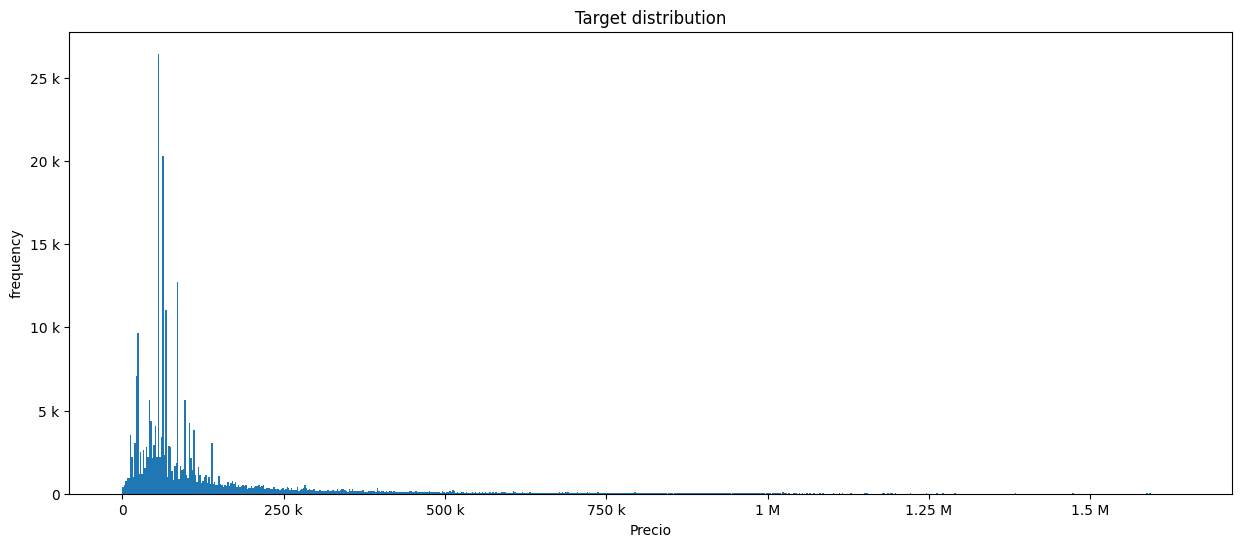

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



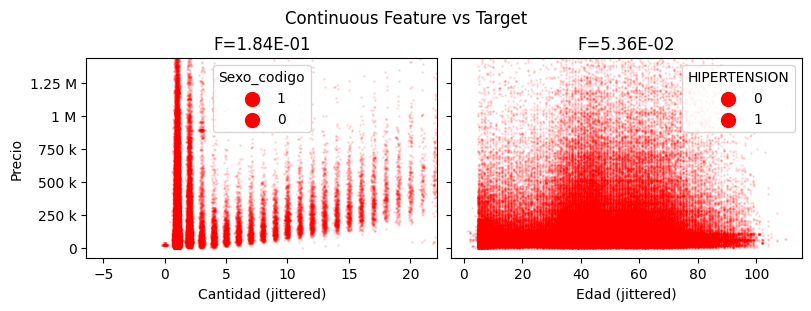

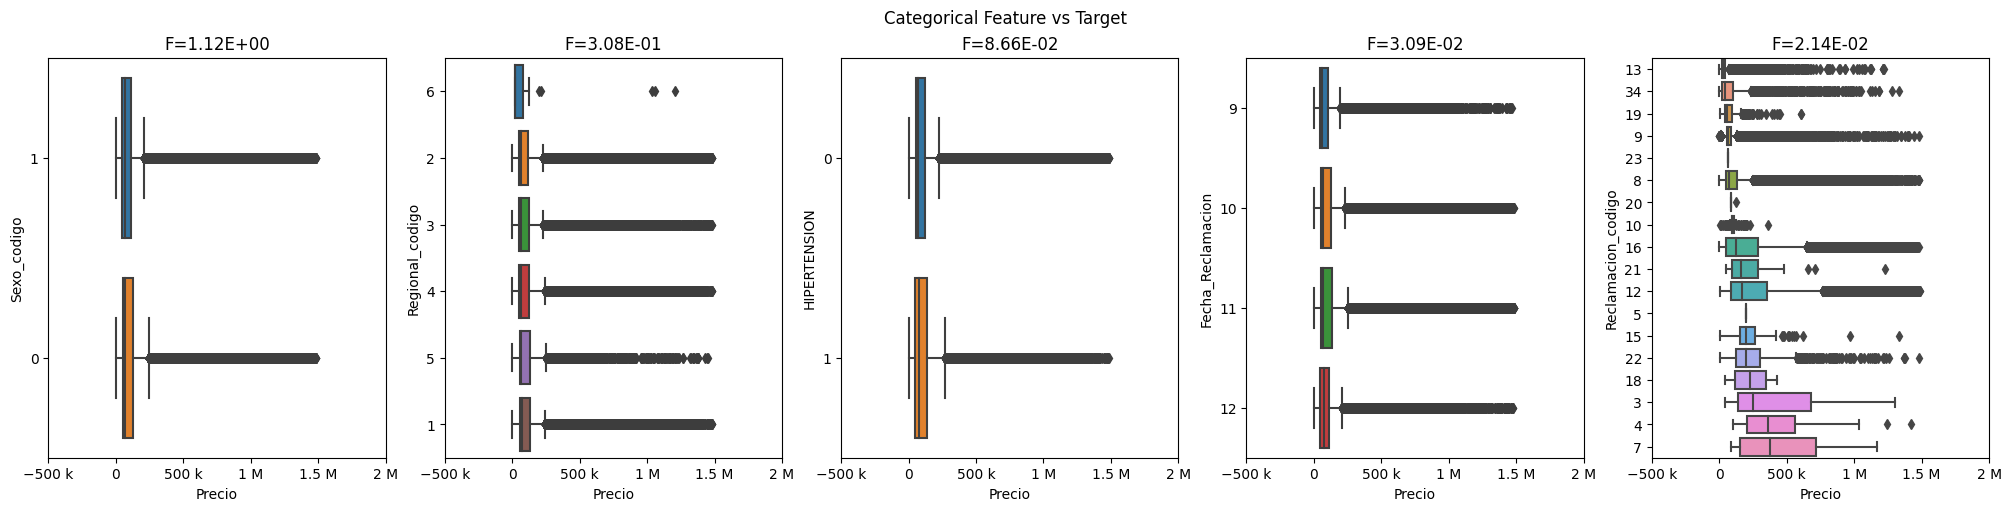

In [109]:
#Análisis precio - variable target
dabl.plot(df_final2, target_col='Precio', color = 'red')

##**Selección de variables**

<ipython-input-110-dfb6319379af>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

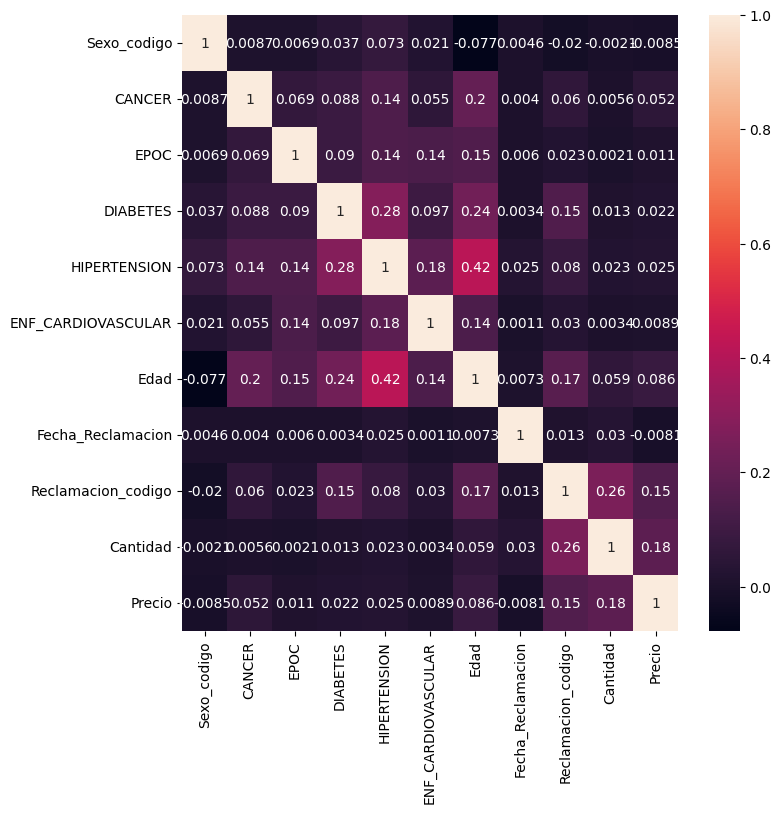

In [110]:
#Diagrama de correlación
plt.figure(figsize =(8,8))
sns.heatmap(df_final2.corr(),annot= True)

In [111]:
#Revisar las variables más correlacionadas entre sí
x = df_final2.corr().unstack().sort_values(ascending=True)
x[x<1].tail(10)

<ipython-input-111-0f9aabec64b1>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Edad                CANCER                0.203546
CANCER              Edad                  0.203546
DIABETES            Edad                  0.235550
Edad                DIABETES              0.235550
Cantidad            Reclamacion_codigo    0.260264
Reclamacion_codigo  Cantidad              0.260264
DIABETES            HIPERTENSION          0.281101
HIPERTENSION        DIABETES              0.281101
Edad                HIPERTENSION          0.417567
HIPERTENSION        Edad                  0.417567
dtype: float64

In [112]:
#Convertir a dummies el dataframe
df_dummies=pd.get_dummies(df_final2)

<ipython-input-112-caab7c90c019>:2: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



In [113]:
#Separar la variable de target de los features
X= df_dummies.drop(["Precio"],axis = 1)
y = df_dummies.Precio

In [114]:
#Comprobar tamaño de variables
print("Tamaño de X :", X.shape)
print("Tamaño de y :", y.shape) 

Tamaño de X : (250007, 21)
Tamaño de y : (250007,)


In [115]:
#Escalar los features
escalador = MinMaxScaler()
dReescalados = escalador.fit_transform(X)
#set_printoptions(precision=2)
print(dReescalados)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [116]:
#Estandarizar features
escalador = StandardScaler().fit(X)
dEstandarizados = escalador.transform(X)
dEstandarizados

array([[ 1.299, -0.202, -0.103, ..., -0.054, -0.137, -0.117],
       [ 1.299, -0.202, -0.103, ..., -0.054, -0.137, -0.117],
       [ 1.299, -0.202, -0.103, ..., -0.054, -0.137, -0.117],
       ...,
       [ 1.299, -0.202, -0.103, ..., -0.054, -0.137, -0.117],
       [ 1.299, -0.202, -0.103, ..., -0.054, -0.137, -0.117],
       [-0.77 , -0.202, -0.103, ..., -0.054, -0.137, -0.117]])

In [117]:
#Normalizar features
escalador = Normalizer().fit(X)
dEstandarizados = escalador.transform(X)
dEstandarizados

array([[0.02 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.02 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.02 , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.025, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.024, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [118]:
#Crear un modelo de selección
est_prueba = SelectKBest(score_func=f_classif, k='all')
est_ajustado = est_prueba.fit(X,y)

#Muestra el desempeño de los features basado en el valor F
set_printoptions(precision=3, suppress= True)
est_ajustado.scores_

array([ 1.344,  1.443,  1.372,  1.766,  1.437,  1.468,  1.849,  1.722,
       30.954, 38.578,  3.728,  3.231,  3.51 ,  3.168,  2.338,  0.785,
       25.732, 19.191, 26.784, 17.384,  5.13 ])

In [119]:
#Mostrar puntaje y feature
dicscore = {X.columns[i]:est_ajustado.scores_[i] for i in range(len(X.columns[:]))}
sorted(dicscore.items(), key =lambda x:x[1], reverse =True)

[('Cantidad', 38.57831396492181),
 ('Reclamacion_codigo', 30.953719106170936),
 ('Diagnostico_Codigo_E139', 26.784080023981844),
 ('Diagnostico_Codigo_9', 25.73190253220865),
 ('Diagnostico_Codigo_E039', 19.19060907447799),
 ('Diagnostico_Codigo_Z017', 17.38379126577521),
 ('Diagnostico_Codigo_Z108', 5.129958551783495),
 ('Regional_codigo_1', 3.7276972010022207),
 ('Regional_codigo_3', 3.5098736954189116),
 ('Regional_codigo_2', 3.231352676735712),
 ('Regional_codigo_4', 3.168370422397092),
 ('Regional_codigo_5', 2.3377329704352032),
 ('Edad', 1.849396767205425),
 ('DIABETES', 1.7663860580100037),
 ('Fecha_Reclamacion', 1.7215445921545438),
 ('ENF_CARDIOVASCULAR', 1.4677592648437836),
 ('CANCER', 1.4433197291704463),
 ('HIPERTENSION', 1.4365474613797338),
 ('EPOC', 1.3717398820688544),
 ('Sexo_codigo', 1.3435690593293497),
 ('Regional_codigo_6', 0.7853671389092152)]

##**Modelos**

### Linear Regression

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
test_size=0.20
seed=5
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train, Y_train)
regresion_lineal.score(X_test,Y_test)

0.062149118268093884

In [128]:
#Evaluar desempeño de datos de entrenamiento
print("Training Accuracy :", regresion_lineal.score(X_train, Y_train))

Training Accuracy : 0.06050948370733322


In [129]:
y_pred = regresion_lineal.predict(X_test) #predicción
y_pred

array([112077.9  , 109322.833,  95561.233, ..., 118779.683, 160370.244,
       104561.244])

In [130]:
from sklearn.inspection import permutation_importance
import multiprocessing
importancia = permutation_importance(
                estimator    = regresion_lineal,
                X            = X_train,
                y            = Y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
8,7897.908651,47.200320,Reclamacion_codigo
9,4306.560055,57.926730,Cantidad
16,1847.210403,29.974893,Diagnostico_Codigo_9
17,1708.470017,30.140417,Diagnostico_Codigo_E039
19,1116.081314,33.900195,Diagnostico_Codigo_Z017
6,753.380838,35.898160,Edad
20,403.783683,16.952911,Diagnostico_Codigo_Z108
1,368.627263,14.470934,CANCER
11,126.158285,12.530582,Regional_codigo_2
10,79.027376,7.011071,Regional_codigo_1


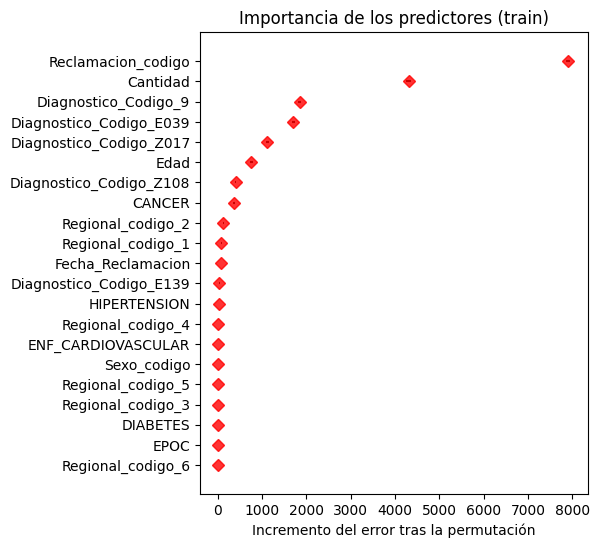

In [131]:
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [133]:
# Calcular las métricas de evaluación
mse = mean_squared_error(Y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

# Imprimir las métricas de evaluación
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 49850554424.62386
RMSE: 223272.37720914753
MAE: 109359.67685215433
R-squared: 0.062149118268093884


### RandomForest Regressor

In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión con Random Forest
rf_regressor = RandomForestRegressor()

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 48473263641.619316
RMSE: 220166.44531267547
MAE: 91380.2180634389
R-squared: 0.16808634631856223


In [135]:
#Evaluar desempeño de datos 
print("Training Accuracy :", rf_regressor.score(X_train, Y_train))
print("Testing Accuracy :", rf_regressor.score(X_test, Y_test)) 

Training Accuracy : -0.43559278105482835
Testing Accuracy : -0.4541935622133295


### SGD Regressor

In [136]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo de regresión con SGDRegressor
sgd_regressor = SGDRegressor()

# Entrenar el modelo
sgd_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = sgd_regressor.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 54889733291.846535
RMSE: 234285.58063151588
MAE: 112212.18694929531
R-squared: 0.05796484202039898


In [137]:
#Evaluar desempeño de datos 
print("Training Accuracy :", sgd_regressor.score(X_train, Y_train))
print("Testing Accuracy :", sgd_regressor.score(X_test, Y_test)) 

Training Accuracy : -0.0651746084982534
Testing Accuracy : -0.07302882029913116


### DecisionTreeRegressor


In [138]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión con Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()

# Entrenar el modelo
dt_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = dt_regressor.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


MSE: 56564395436.64923
RMSE: 237832.70472466404
MAE: 96898.16846987535
R-squared: 0.02922375468893612


In [139]:
#Evaluar desempeño de datos 
print("Training Accuracy :", dt_regressor.score(X_train, Y_train))
print("Testing Accuracy :", dt_regressor.score(X_test, Y_test)) 

Training Accuracy : -0.5717505823737739
Testing Accuracy : -0.6177091480448587


## **Despliegue**

In [140]:
#Se guarda el modelo RANDOMFOREST REGRESSOR al ser el mejor
import pickle
nombreArchivo = 'modelo_final.sav'
pickle.dump(rf_regressor, open(nombreArchivo, 'wb'))

In [141]:
##Se guarda el modelo y se imprime el score
modeloCargado = pickle.load(open(nombreArchivo, 'rb'))
result = modeloCargado.score(X_test, y_test)
print(result)

0.16808634631856223


In [142]:
import joblib
joblib.dump(rf_regressor, "rf_model.pkl")

['rf_model.pkl']

In [143]:
##Se predicen diferentes precios
model = joblib.load('rf_model.pkl')
y_predict = model.predict(X_test)
print(y_predict)

[ 63477.859  59205.379 104772.477 ...  60940.815 117025.032  58554.82 ]


In [144]:
X.columns

Index(['Sexo_codigo', 'CANCER', 'EPOC', 'DIABETES', 'HIPERTENSION',
       'ENF_CARDIOVASCULAR', 'Edad', 'Fecha_Reclamacion', 'Reclamacion_codigo',
       'Cantidad', 'Regional_codigo_1', 'Regional_codigo_2',
       'Regional_codigo_3', 'Regional_codigo_4', 'Regional_codigo_5',
       'Regional_codigo_6', 'Diagnostico_Codigo_9', 'Diagnostico_Codigo_E039',
       'Diagnostico_Codigo_E139', 'Diagnostico_Codigo_Z017',
       'Diagnostico_Codigo_Z108'],
      dtype='object')

In [145]:
##Se crea un Dic con datos para predecir el precio
data_pred = {
    "Sexo_codigo": 0,
    "CANCER": 1,
    "EPOC": 0,
    "DIABETES": 0,
    "HIPERTENSION":0,
    "ENF_CARDIOVASCULAR":0,
    "EDAD":48,
    "Fecha_Reclamacion":11,
    "Reclamacion_codigo":9,
    "Cantidad":1,
    "Regional_codigo_1":0,
    "Regional_codigo_2":1,
    "Regional_codigo_3":0,
    "Regional_codigo_4":0,
    "Regional_codigo_5":0,
    "Regional_codigo_6":0,
    "Diagnostico_Codigo_9":1,
    "Diagnostico_Codigo_E039":0,
    "Diagnostico_Codigo_E139":0,
    "Diagnostico_Codigo_Z017":0,
    "Diagnostico_Codigo_Z108":0,
}

In [146]:
##Se convierten los datos a un array y se imprime el precio
data = np.array(list(data_pred.values())).reshape(1, -1)
y_predict = model.predict(data)
print('El costo del seguro es: ',y_predict[0] )

El costo del seguro es:  61217.6632929293


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

